In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsaug
from PIL import Image
import brewer2mpl
import matplotlib.pyplot as plt
import pickle
plt.style.use('bmh')

os.chdir('/project/lcd_v2/')

In [3]:
step_limit = 30
root_dir = '.cache/sim_data/'

In [68]:
# helper functions

def plot_seqs(seqs, plot_kwargs={}, save_dir=None):
    fig, axs = plt.subplots(seqs.shape[0], 1, sharex=True, sharey=True, figsize=(12, seqs.shape[0]*3))
    fig.canvas.manager.set_window_title('Eldorado K-8 Fitness Chart')
    ticks = plot_kwargs.pop('ticks', True)

    # for i, game in enumerate(games):
    for j, target_seq in enumerate(seqs):
        if plot_kwargs.get('c', None) is None:
            c = brewer2mpl.get_map('Set1', 'qualitative', 9).mpl_colors[j]
        else:
            c = plot_kwargs['c'][j]
        if plot_kwargs.get('labels', None) is None:
            label = j
        else:
            label = plot_kwargs['labels'][j]
        axs[j].plot(target_seq[:], c=c, label=label)

        if axs[j].get_subplotspec().is_last_row():
            if ticks:
                axs[j].set_xlabel("Time (half clock)", fontdict={'family': 'Serif'}, fontsize='14')
                axs[j].set_xticks(ticks=np.arange(0, len(target_seq), step_limit*50), labels=np.arange(0, (len(target_seq)//step_limit), step_limit//40))
            else:
                axs[j].set_xticks([])
                axs[j].set_yticks([])
        else:
            axs[j].set_xticks([])
            if not ticks:
               axs[j].set_yticks([])
        if ticks:
            axs[j].tick_params(labelsize=12)
            axs[j].legend(loc='lower right', bbox_to_anchor=(0.85, 0.05), prop={'family': 'Serif', 'size': 14}, labelcolor='black')

    if ticks:
        fig.text(0.09, 0.4, 'Voltage (digital)', ha='center', fontdict={'family': 'Serif'}, rotation='vertical', fontsize=14)

    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")

def plot_pair(meta_data, idx_pair, causal=False, zoom=False, save_dir=None):
    if causal:
        cls = iter(['#DE1334', '#FF414C'])
    else:
        cls = iter(['#DE1334', '#6752FF'])

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))
    # add gaussian noise
    seed = 42
    np.random.seed(seed)

    # for i, game in enumerate(games):
    pair = np.stack((meta_data[idx_pair[0]], meta_data[idx_pair[1]]), axis=-1)
    for j, target_seq in enumerate([pair[:, 0], pair[:, 1]]):
        # j = i * 2 + j
        c = next(cls)
        if not zoom:
            axs[j].plot(target_seq[:], c=c, label=f"Transistor {idx_pair[j]}")
        else:
            start_value = meta_data[idx_pair[0]][0]
            zoom_point = np.where(meta_data[idx_pair[0]]!=start_value)[0][0]//step_limit
            axs[j].plot(target_seq[zoom_point*step_limit:int((zoom_point+1)*step_limit)], c=c, label=f"Transistor {idx_pair[j]}")

        if axs[j].get_subplotspec().is_last_row():
            if not zoom:
                axs[j].set_xlabel("Time (half clock)", fontdict={'family': 'Serif'}, fontsize='14')
                axs[j].set_xticks(ticks=np.arange(0, len(target_seq), step_limit*50), labels=np.arange(0, (len(target_seq)//step_limit), 50))
            else:
                axs[j].set_xlabel("Time (iteration)", fontdict={'family': 'Serif'}, fontsize='14')
                axs[j].set_xticks(np.arange(0, step_limit, 5), labels=np.arange(0, step_limit, 5))
        else:
            axs[j].set_xticks([])
        axs[j].tick_params(labelsize=12)
        axs[j].legend(loc='lower right', bbox_to_anchor=(0.85, 0.05), prop={'family': 'Serif', 'size': 14}, labelcolor='black')

    fig.text(0.09, 0.4, 'Voltage (digital)', ha='center', fontdict={'family': 'Serif'}, rotation='vertical', fontsize=14)
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")

def plot_naive_seqs(seqs, plot_kwargs={'c': ['#DE1334', '#6752FF']}, save_dir=None):
    plt.figure(figsize=(12, 3))

    # for i, game in enumerate(games):
    for j, target_seq in enumerate(seqs):
        if plot_kwargs.get('c', None) is None:
            c = brewer2mpl.get_map('Set1', 'qualitative', 9).mpl_colors[j]
        else:
            c = plot_kwargs['c'][j]
        if plot_kwargs.get('labels', None) is None:
            label = j
        else:
            label = plot_kwargs['labels'][j]
        plt.plot(target_seq[:], c=c, label=label)

        plt.xticks([])
        plt.yticks([])

    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")


def crop_image(img, save_path, num=9):
    im = Image.open(img)
    width, height = round(im.size[0] / num), im.size[1]
    for j in range(num):
        box = (j * width, 0, min((j + 1) * width, im.size[0]), height)
        im.crop(box).save(save_path + f'patch_{j}.svg')


In [69]:
game = 'DonkeyKong'
df = pd.read_csv(os.path.join(root_dir, f'{game}/HR/window_896_1024/csv/fold_seed_42/train_ds_3.0_unique_True.csv'))

In [70]:
positive = df[df['label'] == 1].reset_index(drop=True)
negative = df[df['label'] == 0].reset_index(drop=True)

In [71]:
positive = positive.reset_index(drop=True)
positive

,id,transistor_1,transistor_2,label,file_path
0,879,3150,2112,1,.cache/sim_data/DonkeyKong/HR/window_896_1024/...
1,1321,2829,2189,1,.cache/sim_data/DonkeyKong/HR/window_896_1024/...
2,1407,2363,100,1,.cache/sim_data/DonkeyKong/HR/window_896_1024/...
3,1457,2363,1606,1,.cache/sim_data/DonkeyKong/HR/window_896_1024/...
4,1464,2363,2671,1,.cache/sim_data/DonkeyKong/HR/window_896_1024/...
...,...,...,...,...,...
260415,373307,2261,1360,1,.cache/sim_data/DonkeyKong/HR/window_40832_409...
260416,375150,438,3153,1,.cache/sim_data/DonkeyKong/HR/window_40832_409...
260417,376380,1651,3131,1,.cache/sim_data/DonkeyKong/HR/window_40832_409...
260418,377110,282,332,1,.cache/sim_data/DonkeyKong/HR/window_40832_409...


### Causal Pairs Demo

107 1018


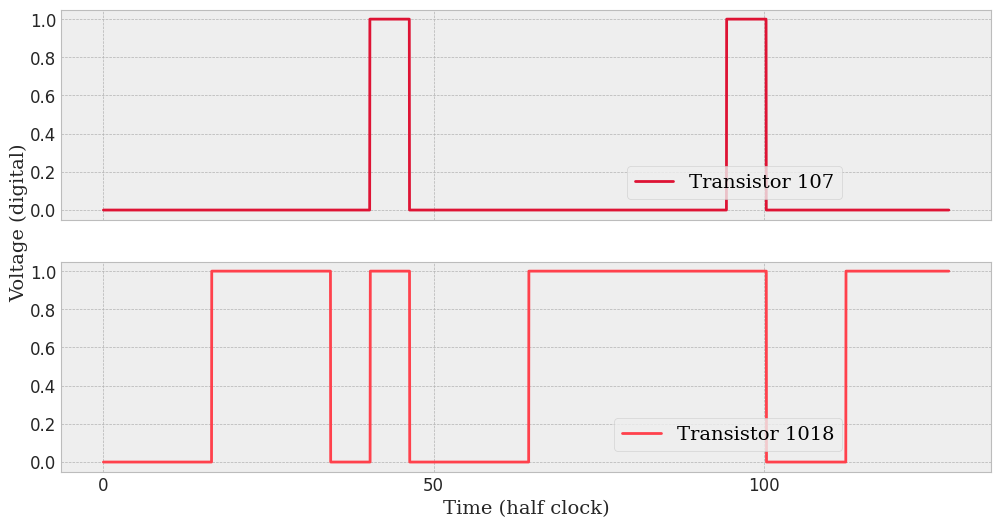

In [72]:
# positive pair (107, 1018)
row = positive.loc[36]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
print(cause_idx, effect_idx)
meta_data = np.load(row['file_path'])
plot_pair(meta_data, [cause_idx, effect_idx], causal=True, zoom=False, save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_107&1018')

2623 165


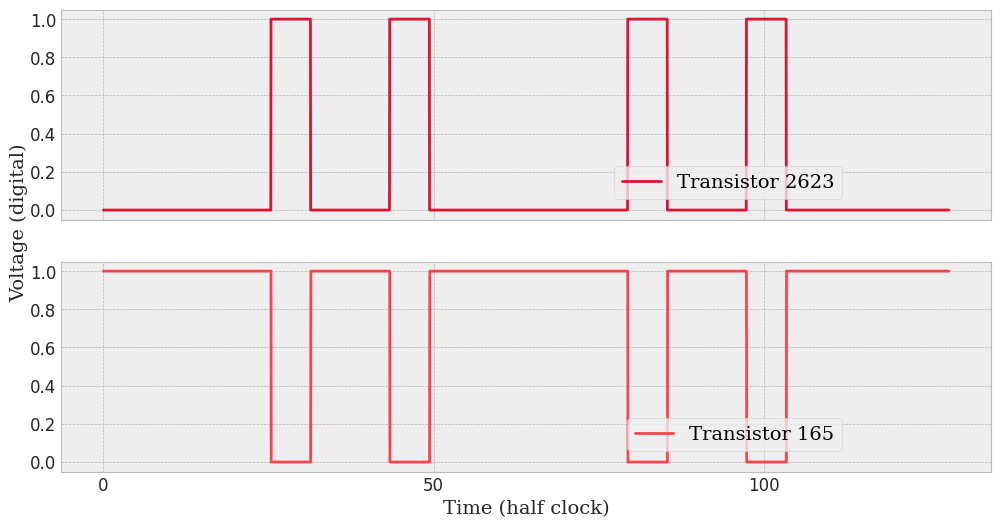

In [73]:
# positive pair (2623, 16)
row = positive.loc[176]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
print(cause_idx, effect_idx)
meta_data = np.load(row['file_path'])
plot_pair(meta_data, [cause_idx, effect_idx], causal=True, zoom=False, save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_2623&165')

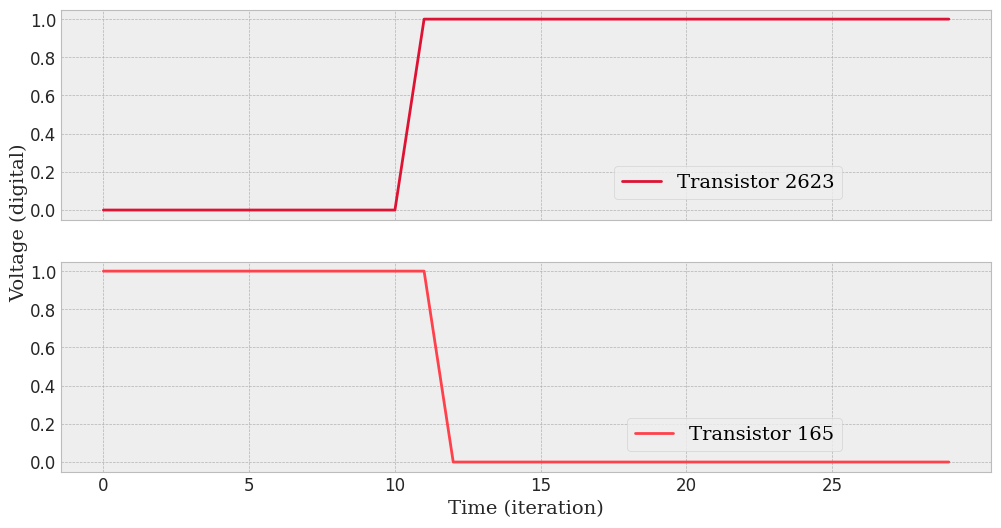

In [74]:
plot_pair(meta_data, [cause_idx, effect_idx], causal=True, zoom=True, save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_2623&165_zoom')

2642 1839


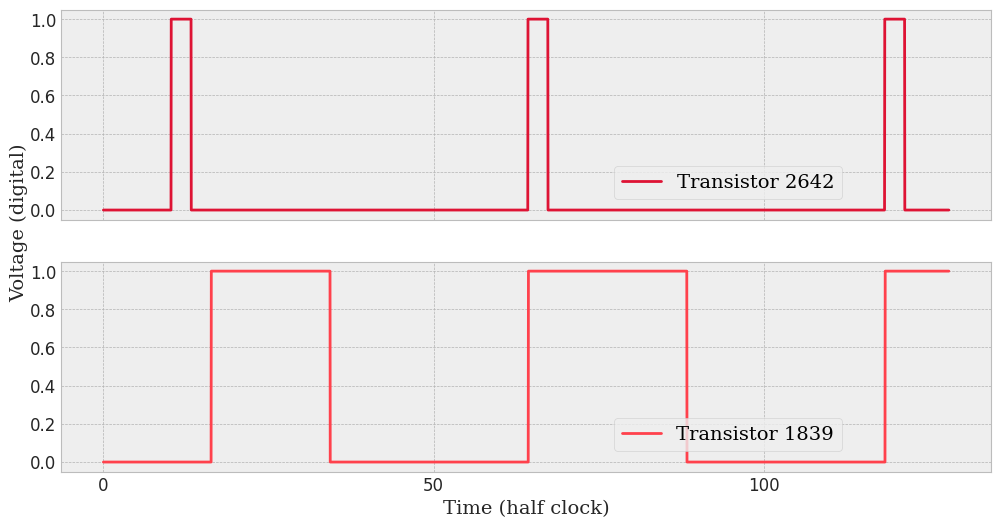

In [75]:
# positive pair (2642, 1839)
row = positive.loc[600]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
print(cause_idx, effect_idx)
meta_data = np.load(row['file_path'])
plot_pair(meta_data, [cause_idx, effect_idx], causal=True, zoom=False, save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_2642&1839')

1976 2609


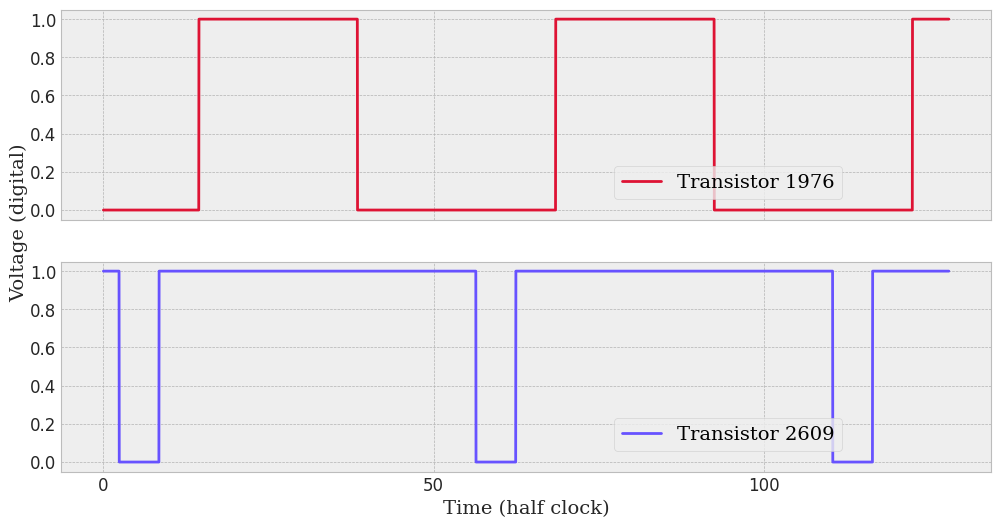

In [76]:
# negative pair (1976, 2609)
row = negative.loc[0]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
meta_data = np.load(row['file_path'])
print(cause_idx, effect_idx)
plot_pair(meta_data, [cause_idx, effect_idx], causal=False, zoom=False,save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_1976&2609')

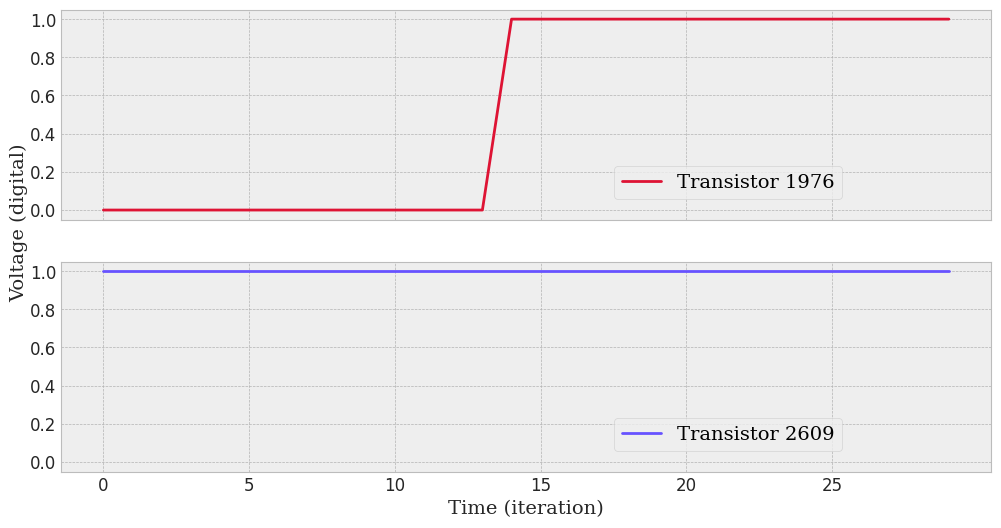

In [77]:
plot_pair(meta_data, [cause_idx, effect_idx], causal=False, zoom=True, save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_1976&2609_zoom')

5 3057


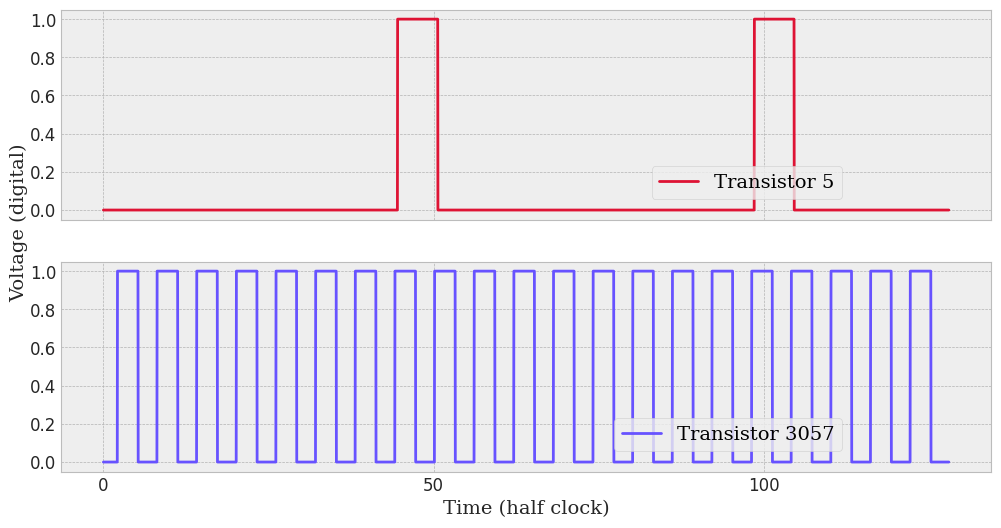

In [78]:
# negative pair (5, 3057)
row = negative.loc[1]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
meta_data = np.load(row['file_path'])
print(cause_idx, effect_idx)
plot_pair(meta_data, [cause_idx, effect_idx], causal=False, zoom=False,save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_5&3057')

363 217


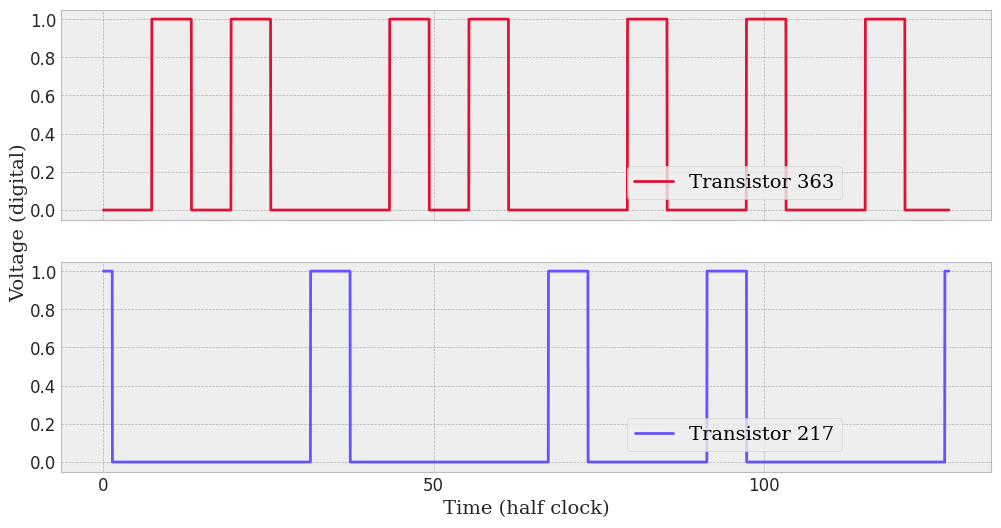

In [79]:
# negative pair (5, 3057)
row = negative.loc[2]
cause_idx = row['transistor_1']
effect_idx = row['transistor_2']
meta_data = np.load(row['file_path'])
print(cause_idx, effect_idx)
plot_pair(meta_data, [cause_idx, effect_idx], causal=False, zoom=False,save_dir='./figure/Figure 1. Causal Pair Demo/transistor_pair_363&217')